# Bruise Detection using Simple CNN

This notebook implements a basic CNN architecture for binary bruise detection (bruise vs normal skin).

In [27]:
%pip install tensorflow numpy matplotlib pillow scikit-learn seaborn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

## Data Loading and Preprocessing

In [28]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if os.path.exists(bruise_path):
        for img_name in os.listdir(bruise_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(bruise_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(1)  # 1 for bruise
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if os.path.exists(normal_path):
        for img_name in os.listdir(normal_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(normal_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(0)  # 0 for normal
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

In [29]:
# Load the dataset
X, y = load_binary_data()
print("Dataset shape:", X.shape)
print("Number of bruise images:", np.sum(y == 1))
print("Number of normal images:", np.sum(y == 0))

Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


## Create and Train Simple CNN Model

In [30]:
def create_simple_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Simple CNN architecture
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer
        layers.Dense(64, activation='relu'),
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [31]:
# Split data
# First split off test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split remaining 90% into train (70%) and validation (20%) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

print("\nData split sizes:")
print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")

# Create the model
input_shape = X_train[0].shape
model = create_simple_model(input_shape)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Display model summary
model.summary()


Data split sizes:
Training set: 317 images (71.7%)
Validation set: 80 images (18.1%)
Test set: 45 images (10.2%)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,433 (96.26 MB)

 Trainable params: 25,234,433 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model using validation set
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),  # Using validation set for monitoring
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - Precision: 0.4947 - Recall: 0.3553 - accuracy: 0.5022 - loss: 10.2454 - val_Precision: 0.5500 - val_Recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 3.2899
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - Precision: 0.5685 - Recall: 0.9875 - accuracy: 0.5696 - loss: 3.2909 - val_Precision: 1.0000 - val_Recall: 0.0455 - val_accuracy: 0.4750 - val_loss: 1.6675
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - Precision: 0.6701 - Recall: 0.3006 - accuracy: 0.5318 - loss: 1.2163 - val_Precision: 0.9615 - val_Recall: 0.5682 - val_accuracy: 0.7500 - val_loss: 0.4687
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - Precision: 0.9523 - Recall: 0.7461 - accuracy: 0.8302 - loss: 0.3974 - val_Precision: 0.8966 - val_Recall: 0.5909 - val_accuracy: 0.7375 - val_loss: 0.4482
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step - Precision: 0.8661 - Recall: 0.8173 - accuracy: 0.8361 - loss: 0.3206 - val_Precision: 0.9250 - val_Recall: 

## Model Evaluation and Analysis

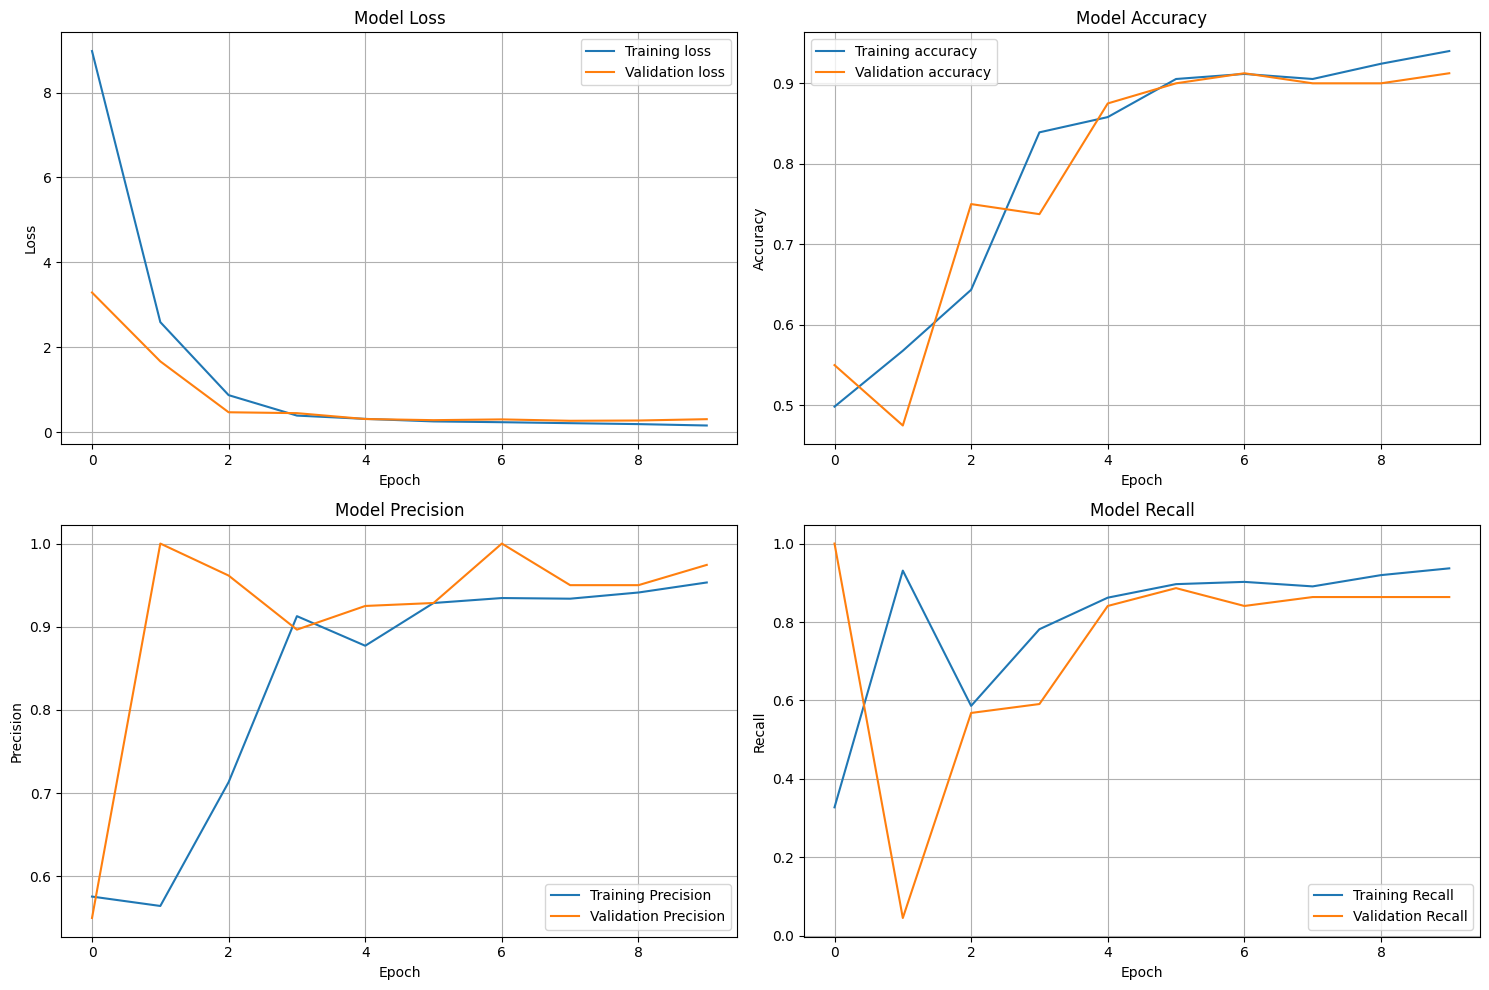

In [33]:
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'Precision', 'Recall']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        
        axes[row, col].plot(history.history[metric], label=f'Training {metric}')
        axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[row, col].set_title(f'Model {metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [34]:
# Print each metric
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Loss: 0.2190
Test Accuracy: 0.8889
Test Precision: 0.9130
Test Recall: 0.8750


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


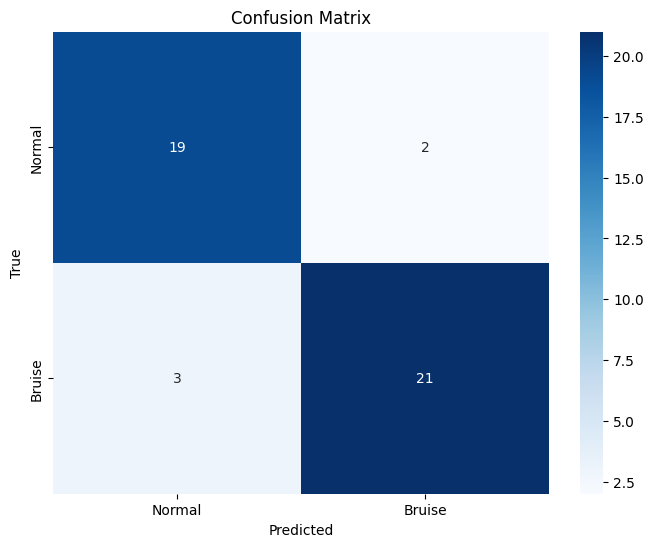


Classification Report:
              precision    recall  f1-score   support

      Normal     0.8636    0.9048    0.8837        21
      Bruise     0.9130    0.8750    0.8936        24

    accuracy                         0.8889        45
   macro avg     0.8883    0.8899    0.8887        45
weighted avg     0.8900    0.8889    0.8890        45



In [35]:
# Make predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Bruise'],
            yticklabels=['Normal', 'Bruise'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Bruise'], digits=4))

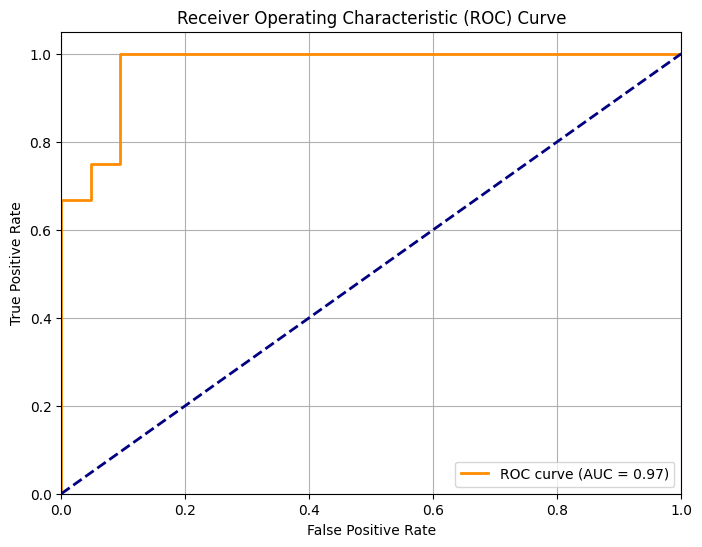

In [36]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Model Interpretation

From the plots and metrics above, we can analyze:

1. **Overfitting/Underfitting**:
   - Compare training vs validation metrics
   - If validation metrics are significantly worse than training, the model might be overfitting
   - If both metrics are poor, the model might be underfitting

2. **Model Performance**:
   - Accuracy: Overall correctness
   - Precision: Ability to avoid false positives
   - Recall: Ability to find all positive cases
   - ROC-AUC: Overall ability to distinguish between classes

3. **Confusion Matrix**:
   - True Negatives (top-left): Correctly identified normal skin
   - False Positives (top-right): Normal skin wrongly classified as bruise
   - False Negatives (bottom-left): Bruises missed
   - True Positives (bottom-right): Correctly identified bruises

In [37]:
# Save the model
model.save('models/bruise_detection_model.h5')
print("Model saved successfully!")

Model saved successfully!
